# Analyze the results given by NAS

## Build the network given by NAS 

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import utils.viz_utils as viz

import matplotlib.pyplot as plt

import matplotlib.animation as animation


#50_partitions
#optimized_parameters = [8.50071696e-04, 3.55273289e-01, 3.86577994e-01, 9.51559796e-01,
# 1.00000000e+00, 1.60000000e+01, 1.57000000e+03]
#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]
#21_partitions_tanh
#optimized_parameters = [6.70771985e-04, 3.71587509e-01, 6.03183109e-01, 8.71381868e-01,
#                        3.22005780e-01, 2.00000000e+00, 1.82000000e+03]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25
by_partitions=False
partition_length=15
activation=''

if(activation):
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions' + '_' + activation + '.json'
    
else:
    eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
    bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
    decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'

/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/anacond

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(51, 1729, 6)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(102, 1729, 6)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(153, 1729, 6)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(204, 1729, 6)
Extracting parameters from /home/davidcalhas/e

In [2]:
n_ica_components = 20

eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, 
                                                                by_partitions=by_partitions,
                                                                partition_length=partition_length, 
                                                                f_resample=f_resample,
                                                                roi=1, roi_ica_components=n_ica_components)

n_voxels = bold_train.shape[1]

n_voxels = bold_train.shape[1]
interval_length = bold_train.shape[2]

print("Finished Loading Data")


_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=1, roi_ica_components=n_ica_components)




Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(24, 6279, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(48, 6279, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(72, 6279, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(96, 6279, 14)
Extracting parameters from /home/davidcalhas/

In [3]:
min_train = np.amin(bold_train)
min_val = np.amin(bold_val)
min_test = np.amin(bold_test)

print(min_train, min_val, min_test)

max_value = np.amin([min_train, min_val, min_test])

print(max_value)

bold_train = bold_train - max_value+0.001
bold_val = bold_val - max_value+0.001
bold_test = bold_test - max_value+0.001

-101.14163 -16.107927 -16.48747
-101.14163


In [4]:
bold_train = np.log(bold_train)
bold_val = np.log(bold_val)
bold_test = np.log(bold_test)

In [5]:
#check number of zeros
#replace zeros voxels with nearby/adjacent voxels

#for ind in bold_test:
#    for voxel in ind:
#        if(not all(x==voxel[0] for x in voxel)):
#            print(voxel)

In [6]:
print(np.amin(bold_train), np.amax(bold_train))
print(np.amin(bold_val), np.amax(bold_val))
print(np.amin(bold_test), np.amax(bold_test))

-6.9077554 7.6342435
4.4430594 5.648491
4.438586 6.1146803


In [7]:
print(np.amin(bold_train, axis=(0,1,2,3)))
print(np.amin(bold_val))
print(np.amin(bold_test))

-6.9077554
4.4430594
4.438586


In [8]:
bold_train[50][1929][11][0] = bold_train[50][1929][12][0]

np.histogram(bold_train)

(array([       1,        0,        0,        0,        0,        0,
               0,    35312,  2285963, 18776164]),
 array([-6.9077554 , -5.4535556 , -3.9993556 , -2.5451558 , -1.0909559 ,
         0.36324406,  1.817444  ,  3.2716439 ,  4.725844  ,  6.1800437 ,
         7.6342435 ], dtype=float32))

In [9]:

#standardize data
#eeg_train, bold_train, eeg_train_scaler, bold_train_scaler = data_utils.standardize(eeg_train, bold_train)
#eeg_val, bold_val, eeg_val_scaler, bold_val_scaler = data_utils.standardize(eeg_val, bold_val)




eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

#eeg_test, bold_test, eeg_test_scaler, bold_test_scaler = data_utils.standardize(eeg_test, bold_test)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Pairs Created


In [10]:
bold_train = bold_train[:,:2607,:,:]
bold_val = bold_val[:,:2607,:,:]
bold_test = bold_test[:,:2607,:,:]

In [11]:
X_train_eeg, X_train_bold, tr_y, X_bold_train_target = data_utils.create_eeg_bold_pairs(eeg_train, bold_train, instances_per_individual=n_partitions)
X_val_eeg, X_val_bold, tv_y, X_bold_val_target = data_utils.create_eeg_bold_pairs(eeg_val, bold_val, instances_per_individual=n_partitions)


tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

<IPython.core.display.Javascript object>


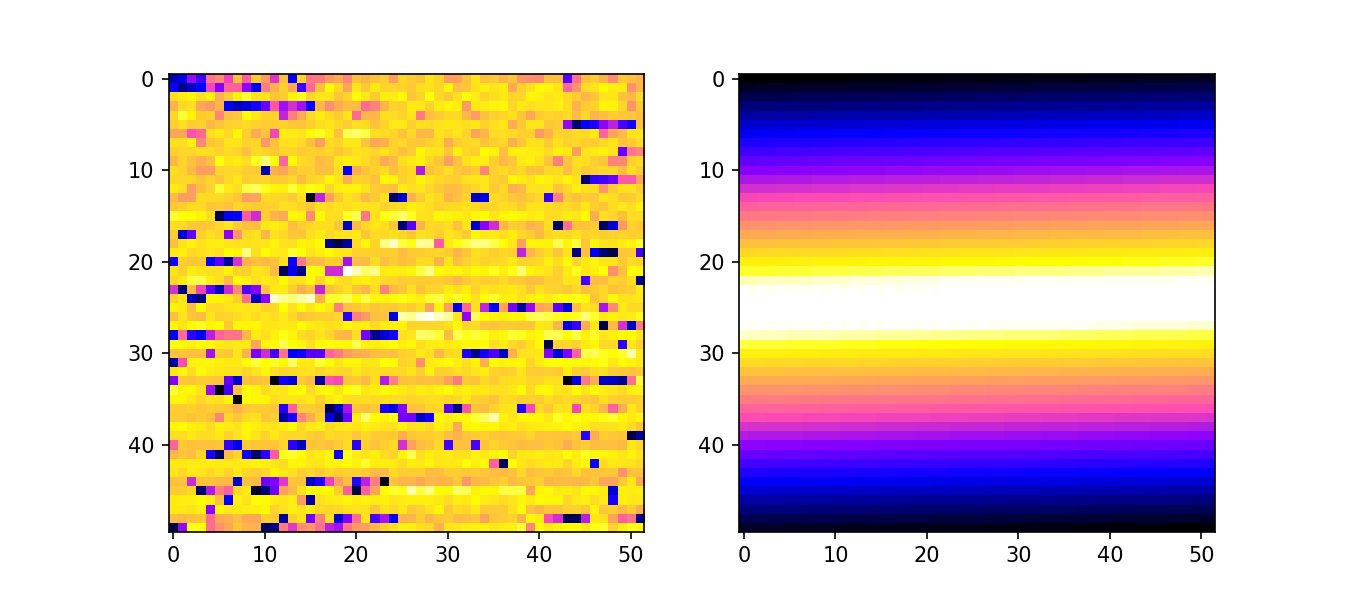

In [40]:
from numpy.linalg import norm

%matplotlib notebook

individual=0
normalize=False

real_mapping = np.copy(bold_train[individual,:, :, 0])
synth_mapping = np.copy(decoder_network(eeg_network(eeg_train)).numpy()[individual,:, :, 0])

if(normalize):
    for voxel in range(len(real_mapping[individual])):
        real_mapping[individual][voxel] = real_mapping[individual][voxel]/norm(real_mapping[individual][voxel])            
        synth_mapping[individual][voxel] = synth_mapping[individual][voxel]/norm(synth_mapping[individual][voxel])

n_frames = real_mapping.shape[1]

fig, axes = plt.subplots(1,2, figsize=(9,4))
ax1, ax2 = axes

ims1 = []
ims2 = []

for frame in range(n_frames):
    im1 = ax1.imshow(np.resize(real_mapping[:,frame], (50, 52)), 
                     cmap='gnuplot2', interpolation='nearest', animated=True)
    im2 = ax2.imshow(np.resize(synth_mapping[:,frame], (50, 52)), 
                     cmap='gnuplot2', interpolation='nearest', animated=True)
    ims1.append([im1])
    ims2.append([im2])

ani1 = animation.ArtistAnimation(fig, ims1, interval=500, blit=True, repeat_delay=1000)
ani2 = animation.ArtistAnimation(fig, ims2, interval=500, blit=True, repeat_delay=1000)

plt.show()

### Train the network

In [34]:
import importlib
importlib.reload(custom_training)
importlib.reload(losses)

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        corr_distance=False, 
                                                        lstm=True,
                                                        gan=True,
                                                        gan_activation="sigmoid",
                                                        gan_output_dimension=1)

validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network,
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            loss_function=losses.get_reconstruction_log_cosine_loss,
                                                            #linear_combination=loss_coefficient,
                                                            linear_combination=1.0,
                                                            clip_value_loss=3.0,
                                                            clip_value_gradient=3.0,
                                                            margin_constrastive=1.5,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y,
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_bold_train_target=X_bold_train_target,
                                                            X_bold_val_target=X_bold_val_target,
                                                            verbose=False)

model_name = "LComb"

KeyboardInterrupt: 

In [19]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

<IPython.core.display.Javascript object>

train set mean:  -2.758675092458725
train set std:  0.04537769358029866
validation set mean:  -2.757316673795382
validation set std:  0.020677870622419558
test set mean:  -2.7833066153526307
test set std:  0.02856865425535633


<IPython.core.display.Javascript object>

train set mean:  -8.242199059327444
train set std:  1.460538184885917


KeyboardInterrupt: 

### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [25]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])


auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)

validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                                                    X_train_bold, 
                                                    auto_encoder_model, 
                                                    epochs=40, 
                                                    auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                    loss_function=losses.get_reconstruction_log_cosine_voxel_loss,
                                                    batch_size=batch_size, 
                                                    X_val_eeg=eeg_val, 
                                                    X_val_bold=bold_val,
                                                    eeg_train=eeg_train, 
                                                    bold_train=bold_train, 
                                                    eeg_val=eeg_val, 
                                                    bold_val=bold_val,
                                                    X_bold_train_target=X_bold_train_target,
                                                    X_bold_val_target=X_bold_val_target)

model_name = "AE"

Autoencoder Loss:  -10.828748 || Validation Autoencoder Loss:  -10.719747
Autoencoder Loss:  -11.404749 || Validation Autoencoder Loss:  -10.719582
Autoencoder Loss:  -11.404813 || Validation Autoencoder Loss:  -10.719464
Autoencoder Loss:  -11.404745 || Validation Autoencoder Loss:  -10.7192545
Autoencoder Loss:  -11.404626 || Validation Autoencoder Loss:  -10.719116
Autoencoder Loss:  -11.404644 || Validation Autoencoder Loss:  -10.719106
Autoencoder Loss:  -11.404571 || Validation Autoencoder Loss:  -10.719559
Autoencoder Loss:  -11.404643 || Validation Autoencoder Loss:  -10.719628
Autoencoder Loss:  -11.404661 || Validation Autoencoder Loss:  -10.71936
Autoencoder Loss:  -11.404887 || Validation Autoencoder Loss:  -10.719167
Autoencoder Loss:  -11.404774 || Validation Autoencoder Loss:  -10.719195
Autoencoder Loss:  -11.404758 || Validation Autoencoder Loss:  -10.719232
Autoencoder Loss:  -11.404664 || Validation Autoencoder Loss:  -10.719314
Autoencoder Loss:  -11.40486 || Valida

train set mean:  -1.7506661196549733
train set std:  0.05706522631845622
validation set mean:  -1.7648733432094257
validation set std:  0.010883043883339473
test set mean:  -1.7656591320037842
test set std:  0.007725250363287546


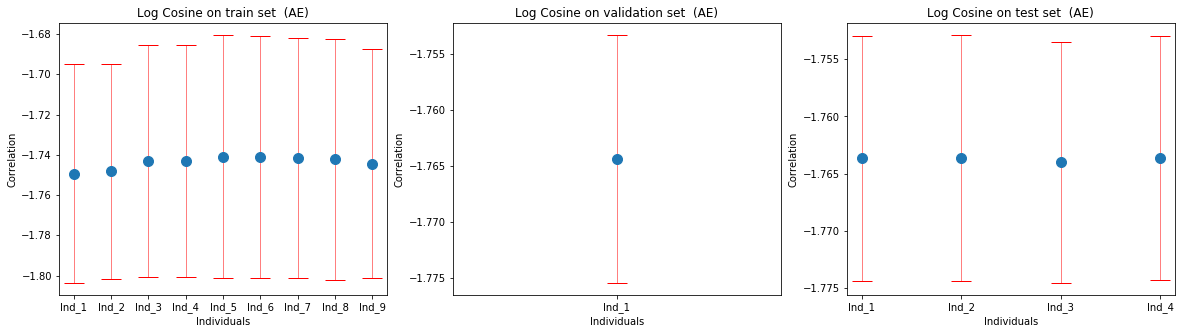

train set mean:  -11.115186067422231
train set std:  1.111482350548589
validation set mean:  -inf
validation set std:  nan
test set mean:  -inf
test set std:  nan


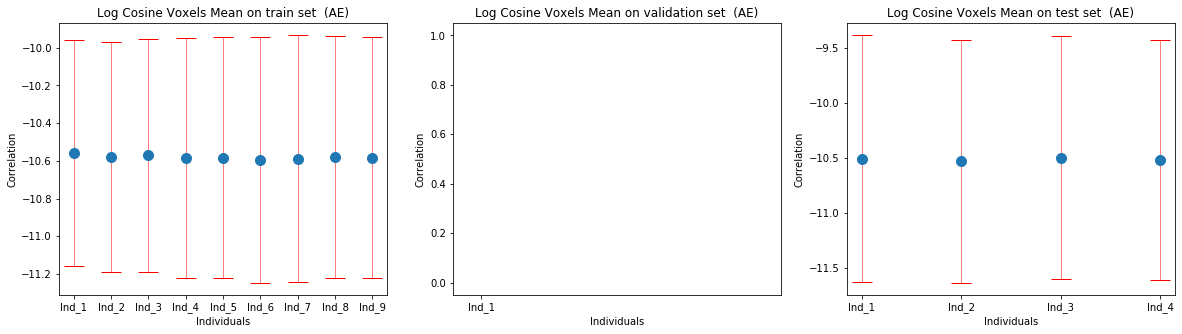

train set mean:  0.826051243642966
train set std:  0.010335819873303051
validation set mean:  0.8287814122935137
validation set std:  0.0018580862024643893
test set mean:  0.8289209133386612
test set std:  0.0013178752170503445


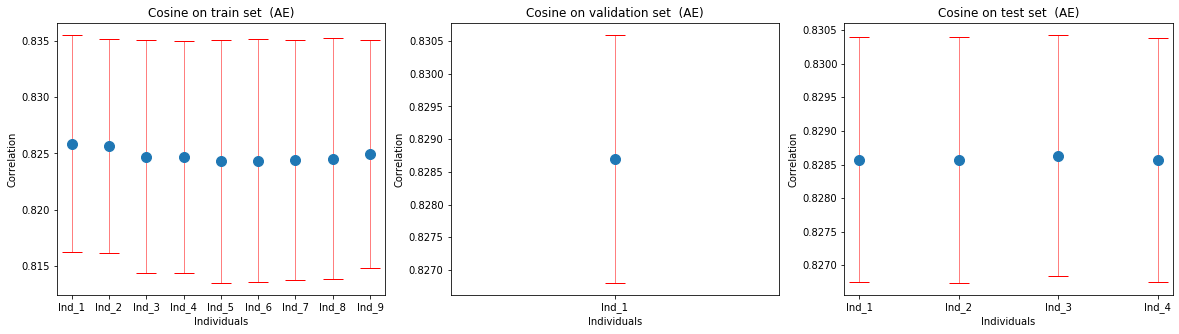

train set mean:  -0.9999748125672341
train set std:  2.2612283936993258e-05
validation set mean:  -0.9999666226406893
validation set std:  2.1623046510825542e-05
test set mean:  -0.9999782955646515
test set std:  2.2780616109536363e-05


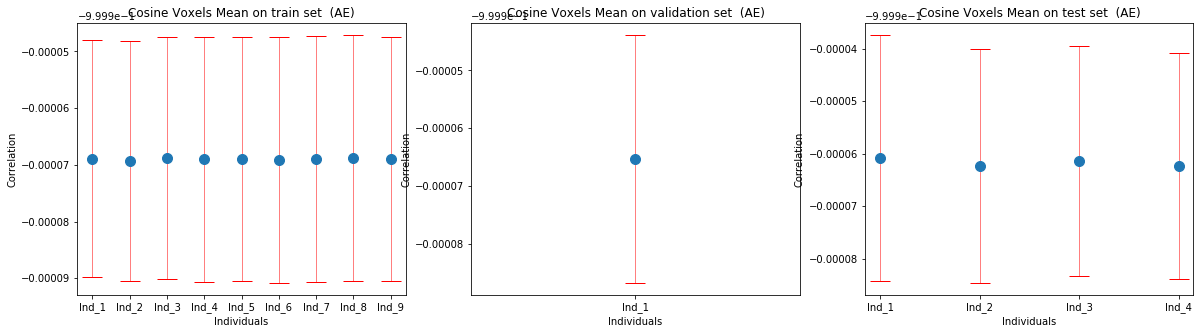

train set mean:  43191.48676757813
train set std:  32.5860554561768
validation set mean:  43656.283935546875
validation set std:  4.382982449061318
test set mean:  43658.7633203125
test set std:  3.52447419680619


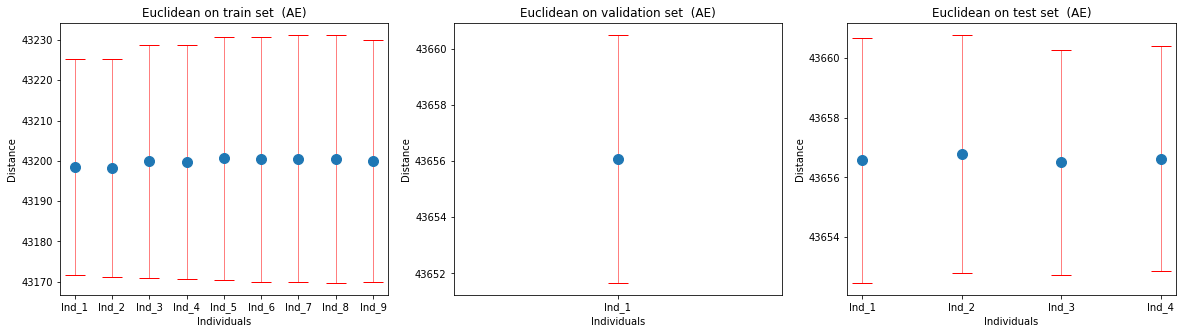

train set mean:  161607.74453125
train set std:  121.92580667843797
validation set mean:  163346.8583984375
validation set std:  16.39967607821811
test set mean:  163356.13359375
test set std:  13.188635609983683


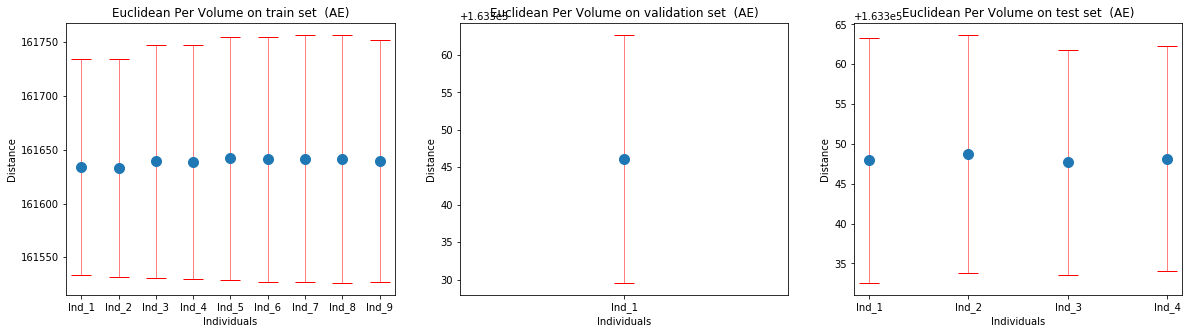

In [21]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try the same hyperparameters, but in an adversarial training process

In [35]:
import tensorflow as tf
import tensorflow.keras.backend as K


def loss_minmax_discriminator(real_pred, real_true, gen_pred, log=False):
    #need to separate positives from negatives

    #log(1) = 0
    positives = np.array([[1., 0., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    #log(1-1) = 0
    negatives = np.array([[0., 1., 0.]], dtype='float32').repeat(real_pred.shape[0],0)
    for instance in range(real_true.shape[0]):
        if(real_true[instance] == 1.0):
            positives[instance] = real_pred[instance][0].numpy()
        else:
            negatives[instance] = real_pred[instance][0].numpy()

    positives = tf.convert_to_tensor(positives)
    negatives = tf.convert_to_tensor(negatives)
    
    if(log):
        loss = (tf.log(positives) + tf.log(1. - negatives) + tf.log(1. - gen_pred)) / 3.
    else:
        

        loss = ((tf.constant(np.array([1., 0., 0.]), dtype="float32") - positives) + \
                (tf.constant(np.array([0., 1., 0.]), dtype="float32") - negatives) + \
                (tf.constant(np.array([0., 0., 1.]), dtype="float32") - gen_pred))
    
    return tf.reduce_mean(loss)


def loss_minmax_generator(gen_pred, log=False):
    
    if(log):
        return tf.reduce_mean(tf.log(gen_pred))
    
    return tf.reduce_mean(tf.abs(tf.constant(np.array([1., 0., 0.]), dtype="float32") - gen_pred))

def grad_decoder_adversarial(discriminator, synthesizer, z, eeg, bold, y_pairs, clip=True, clip_value=2, d_loss=losses.loss_minmax_discriminator, g_loss=losses.loss_minmax_generator):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        
        tape.watch(z)
        tape.watch(synthesizer.variables)

        eeg = tf.convert_to_tensor(eeg)
        bold = tf.convert_to_tensor(bold)
                 
        synthesized = synthesizer(z)

        #pair synthesized with eeg
        real_labels = discriminator([eeg, bold])
        gen_labels = discriminator([eeg, synthesized])
        
        discriminator_loss = d_loss(real_labels, y_pairs, gen_labels)
        synthesizer_loss = g_loss(gen_labels)
        
        if(clip):
            discriminator_loss = tf.clip_by_value(discriminator_loss, -clip_value, clip_value)
            synthesizer_loss = tf.clip_by_value(synthesizer_loss, -clip_value, clip_value)

        return synthesizer_loss, discriminator_loss, tape.gradient(synthesizer_loss, 
                                            synthesizer.trainable_weights)

In [36]:
"""
sensitive_adversarial_training: Adversarial Training

Changing from training the D/G based on the accuracy of G/D given a threshold (0.5)
        
"""
def sensitive_adversarial_training(X_train_eeg, X_train_bold, tr_y, eeg_network, 
    decoder_model, multi_modal_model, epochs=10, 
    discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    g_loss_function=losses.loss_minmax_generator,
    d_loss_function=losses.loss_minmax_discriminator,
    linear_combination=1.0, 
    clip=True,
    clip_value_gradient=0.5, 
    clip_value_loss=2, 
    batch_size=128,
    X_val_eeg=None, X_val_bold=None, tv_y=None, 
    eeg_train=None, bold_train=None, eeg_val=None, bold_val=None,
    X_bold_train_target=None,
    X_bold_val_target=None,
    session=None, verbose=1):


    validation = False
    if(X_val_eeg is not None and X_val_bold is not None and tv_y is not None):
        validation = True

    global_step = tf.Variable(0)
    
    training_d = True
    training_g = False

    _losses = custom_training.custom_training_loss()
    n_epochs = 0

    while(n_epochs < epochs):
        if(training_d):
            print("Training Discriminator")
        elif(training_g):
            print("Training Generator")
        
        decoder_loss = _losses.get_batch_decoder_loss_avg()
        encoder_loss = _losses.get_batch_encoder_loss_avg()
        
        if(training_d and decoder_loss > encoder_loss and encoder_loss != np.inf):
            print("Finished Discriminator\nChanging to Generator")
            training_d = False
            training_g = True
            _losses = custom_training.custom_training_loss()
        elif(training_g and encoder_loss > decoder_loss):
            print("Finished Generator\nChanging to Discriminator")
            training_d = True
            training_g = False
            n_epochs += 1
            _losses = custom_training.custom_training_loss()
        
        for batch_init in range(0, len(X_train_eeg), batch_size):
            batch_start = batch_init
            if(batch_start + batch_size >= len(X_train_eeg)):
                batch_stop = len(X_train_eeg)
            else:
                batch_stop = batch_start + batch_size
            
            shared_eeg = eeg_network(tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]))
            
            if(training_g):
                # Optimize the synthesizer mode
                decoder_loss, encoder_loss, decoder_grads = grad_decoder_adversarial(multi_modal_model, decoder_model, 
                                                                        shared_eeg,
                                                                        tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]), 
                                                                        tf.gather_nd(bold_train, X_train_bold[batch_start:batch_stop]), 
                                                                        tr_y[batch_start:batch_stop],
                                                                        d_loss=d_loss_function,
                                                                        g_loss=g_loss_function,
                                                                        clip=clip,
                                                                        clip_value=clip_value_loss)
                with tf.name_scope("gradient_decoder") as scope:
                    generator_optimizer.apply_gradients(zip(decoder_grads, decoder_model.trainable_variables), name=scope)
                
            elif(training_d):
                #now train the compression by correlation model
                encoder_loss, decoder_loss, encoder_grads = custom_training.grad_multi_encoder_adversarial(multi_modal_model, decoder_model, 
                                                                        shared_eeg,
                                                                        tf.gather_nd(eeg_train, X_train_eeg[batch_start:batch_stop]), 
                                                                        tf.gather_nd(bold_train, X_train_bold[batch_start:batch_stop]), 
                                                                        tr_y[batch_start:batch_stop],
                                                                        d_loss=d_loss_function,
                                                                        g_loss=g_loss_function,
                                                                        clip=clip,
                                                                        clip_value=clip_value_loss)
                
                with tf.name_scope("gradient_encoders") as scope:
                    if(clip):
                        encoder_clipped_grads = ()
                        for grad in encoder_grads:
                            encoder_clipped_grads += (tf.clip_by_value(grad, clip_value_min=-clip_value_gradient, clip_value_max=clip_value_gradient), )
                        encoder_grads=encoder_clipped_grads
                        
                    discriminator_optimizer.apply_gradients(zip(encoder_grads, multi_modal_model.trainable_variables), name=scope)
                
            # Track progress
            _losses.update_batch_decoder_loss_avg(decoder_loss)
            _losses.update_batch_encoder_loss_avg(encoder_loss)

        # end epoch
        decoder_loss = _losses.get_batch_decoder_loss_avg()
        encoder_loss = _losses.get_batch_encoder_loss_avg()

        #get validation analyses
        #get validation analyses
        shared_eeg_train = eeg_network(tf.gather_nd(eeg_train, X_train_eeg))
        shared_eeg_val = eeg_network(tf.gather_nd(eeg_val, X_val_eeg))
        train_reconstruction_loss = losses.get_reconstruction_log_cosine_loss(decoder_model(shared_eeg_train), tf.gather_nd(bold_train, X_train_bold))
        val_reconstruction_loss = losses.get_reconstruction_log_cosine_loss(decoder_model(shared_eeg_val), tf.gather_nd(bold_val, X_val_bold))
        
        if(verbose):
            print("GAN Encoder Loss: ", tf.keras.backend.eval(encoder_loss), 
                " || GAN Decoder Loss: ", tf.keras.backend.eval(decoder_loss),
                " || Train Reconstruction Loss: ", tf.keras.backend.eval(train_reconstruction_loss),
                " || Validation Reconstruction Loss: ", tf.keras.backend.eval(val_reconstruction_loss))
            sys.stdout.flush()

    shared_eeg_val = eeg_network(tf.gather_nd(eeg_val, X_val_eeg))
    return tf.keras.backend.eval(custom_training.loss_decoder(decoder_model(shared_eeg_val), tf.gather_nd(bold_val, X_val_bold)))

In [39]:
import importlib
importlib.reload(custom_training)

eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, 
                                                        dcca=False, 
                                                        lstm=True,
                                                        corr_distance=False,
                                                        gan=True,
                                                        gan_activation="sigmoid",
                                                        gan_output_dimension=3)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                       X_train_bold, 
                                       tr_y, 
                                       eeg_network, decoder_network, multi_modal_model, 
                                       epochs=5, 
                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                       batch_size=batch_size, 
                                       g_loss_function=loss_minmax_generator,
                                       d_loss_function=loss_minmax_discriminator,
                                       linear_combination=loss_coefficient, 
                                       clip=True,
                                       clip_value_loss=3.0,
                                       clip_value_gradient=3.0,
                                       X_val_eeg=X_val_eeg, 
                                       X_val_bold=X_val_bold, 
                                       tv_y=tv_y,
                                       eeg_train=eeg_train, 
                                       bold_train=bold_train, 
                                       eeg_val=eeg_val, 
                                       bold_val=bold_val,
                                       X_bold_train_target=X_bold_train_target,
                                       X_bold_val_target=X_bold_val_target)

model_name = "GAN"

GAN Encoder Loss:  -0.6357125  || GAN Decoder Loss:  0.33268905  || GAN Validation Decoder Loss:  -1.9927685  || Train Reconstruction Loss:  -1.9781184  || Validation Reconstruction Loss:  -1.9927685
GAN Encoder Loss:  -0.6657873  || GAN Decoder Loss:  0.33331814  || GAN Validation Decoder Loss:  -1.9926883  || Train Reconstruction Loss:  -1.9780399  || Validation Reconstruction Loss:  -1.9926883


KeyboardInterrupt: 

In [ ]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Try to check if alternate training between LComb and GAN training

In [30]:
#eeg_network, bold_network, decoder_network = get_models_and_shapes()

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=5, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

Encoder Loss:  0.118197516  || Decoder Loss:  -0.10892728 Validation Decoder Loss:  -0.34396172
Encoder Loss:  0.17350961  || Decoder Loss:  -0.21215793 Validation Decoder Loss:  -0.417525
Encoder Loss:  0.17483221  || Decoder Loss:  -0.21957809 Validation Decoder Loss:  -0.42274988
Encoder Loss:  0.17368379  || Decoder Loss:  -0.22170837 Validation Decoder Loss:  -0.42290154
Encoder Loss:  0.17259873  || Decoder Loss:  -0.22295734 Validation Decoder Loss:  -0.42123955
GAN Encoder Loss:  1.0127182  || GAN Decoder Loss:  0.14818361  || GAN Validation Decoder Loss:  -0.7285427  || Train Reconstruction Loss:  0.083577104  || Validation Reconstruction Loss:  0.5169993
GAN Encoder Loss:  0.5068348  || GAN Decoder Loss:  0.5557646  || GAN Validation Decoder Loss:  -0.36623427  || Train Reconstruction Loss:  0.12438231  || Validation Reconstruction Loss:  0.30665627
GAN Encoder Loss:  0.24195859  || GAN Decoder Loss:  1.0542921  || GAN Validation Decoder Loss:  -0.2962604  || Train Reconstruc

train set mean:  -0.13035505447935844
train set std:  0.10439693812962365
validation set mean:  -0.2702327285494123
validation set std:  0.007279591704164774
test set mean:  -0.2692250900325321
test set std:  0.013276322805917784


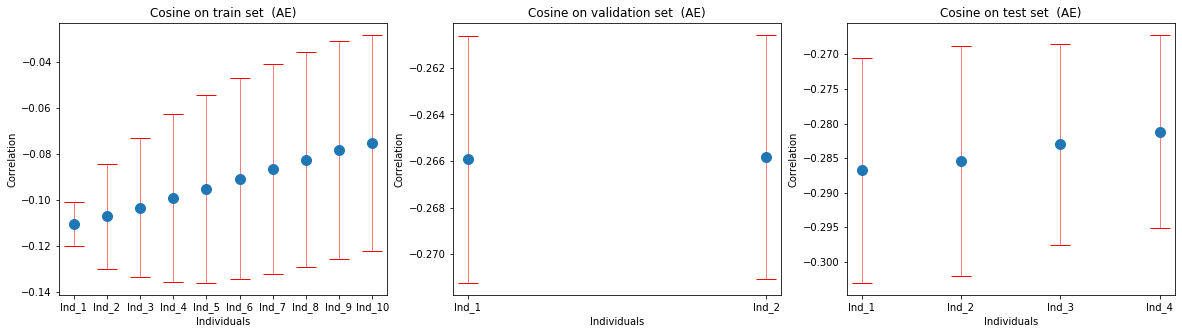

train set mean:  217.21822008405414
train set std:  33.241409173264245
validation set mean:  1998.391369047619
validation set std:  2.57665969646488
test set mean:  1995.119361514137
test set std:  6.124074982564129


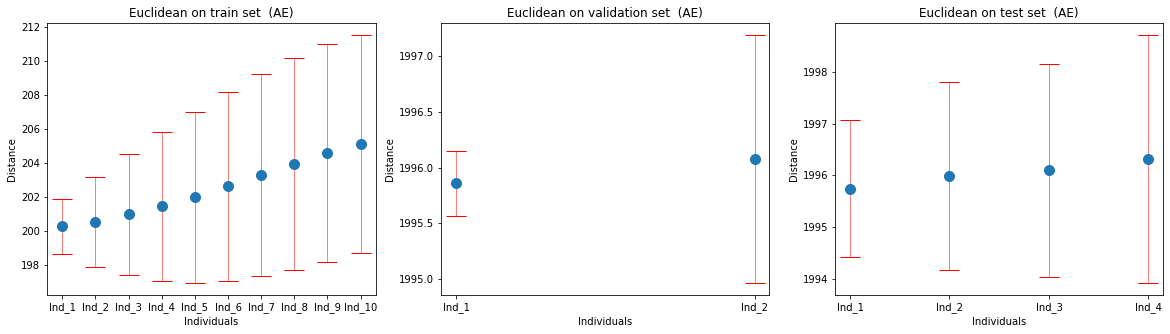

In [31]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)

### Top-K ranking synthesis

In [29]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.ranked_synthesis_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            bold_network=bold_network, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            loss_function=losses.get_reconstruction_log_cosine_loss,
                                                            batch_size=batch_size, 
                                                            top_k=1, 
                                                            eeg_train=eeg_train, 
                                                            bold_train=bold_train, 
                                                            eeg_val=eeg_val, 
                                                            bold_val=bold_val,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name="Top-5"


#1 - 
#2 - 
#3 - 
#4 - 
#5 - 
#6 - 
#7 - 
#8 - 
#9 - 
#10 - 

Encoder Loss:  0.11282042
Encoder Loss:  0.11160814
Encoder Loss:  0.11156601
Encoder Loss:  0.111565895
Encoder Loss:  0.1115658
Encoder Loss:  0.11156566
Encoder Loss:  0.11156551
Encoder Loss:  0.111565374
Encoder Loss:  0.11156522
Encoder Loss:  0.11156504
Encoder Loss:  0.111564845
Encoder Loss:  0.111564696
Encoder Loss:  0.1115645
Encoder Loss:  0.11156437
Encoder Loss:  0.11156421
Encoder Loss:  0.11156412
Encoder Loss:  0.11156404
Encoder Loss:  0.11156403
Encoder Loss:  0.11156394
Encoder Loss:  0.111563906
Encoder Loss:  0.1115639
Encoder Loss:  0.11156388
Encoder Loss:  0.11156386
Encoder Loss:  0.11156385
Encoder Loss:  0.11156383
Encoder Loss:  0.1115638
Encoder Loss:  0.11156379
Encoder Loss:  0.11156379
Encoder Loss:  0.11156379
Encoder Loss:  0.11156376
Encoder Loss:  0.11156376
Encoder Loss:  0.11156376
Encoder Loss:  0.11156374
Encoder Loss:  0.11156373
Encoder Loss:  0.11156374
Encoder Loss:  0.111563735
Encoder Loss:  0.11156371
Encoder Loss:  0.11156371
Encoder Lo

train set mean:  -3.691014379262924
train set std:  0.053199456812835014
validation set mean:  -3.7480901976426444
validation set std:  0.0076260561322854525
test set mean:  -3.729722521305084
test set std:  0.02538251726273856


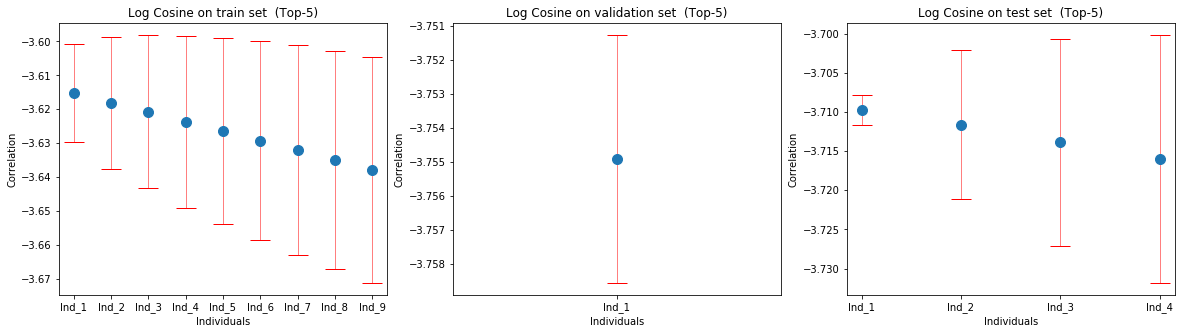

train set mean:  -10.957150852680206
train set std:  0.5932736581227831
validation set mean:  -9.867431104183197
validation set std:  0.11899969277373315
test set mean:  -9.699605426788331
test set std:  0.32679610580100976


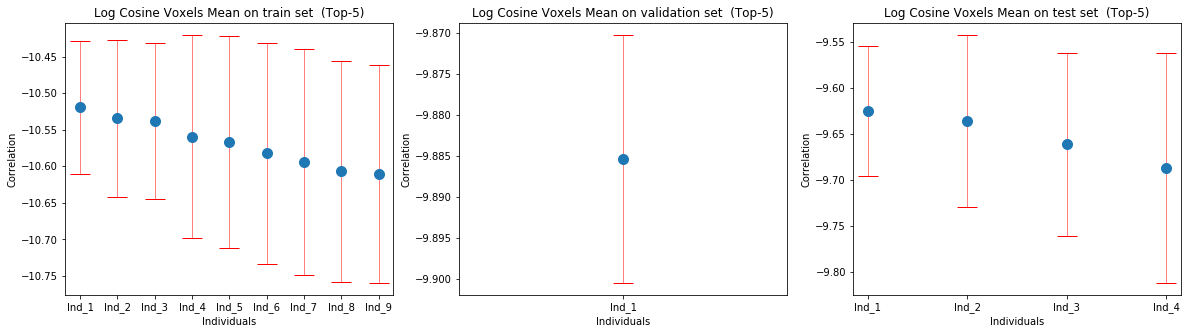

train set mean:  0.9750175930559635
train set std:  0.0013512266293394556
validation set mean:  0.9764366100231806
validation set std:  0.00017970272913722207
test set mean:  0.9759927743673324
test set std:  0.0006096190013035258


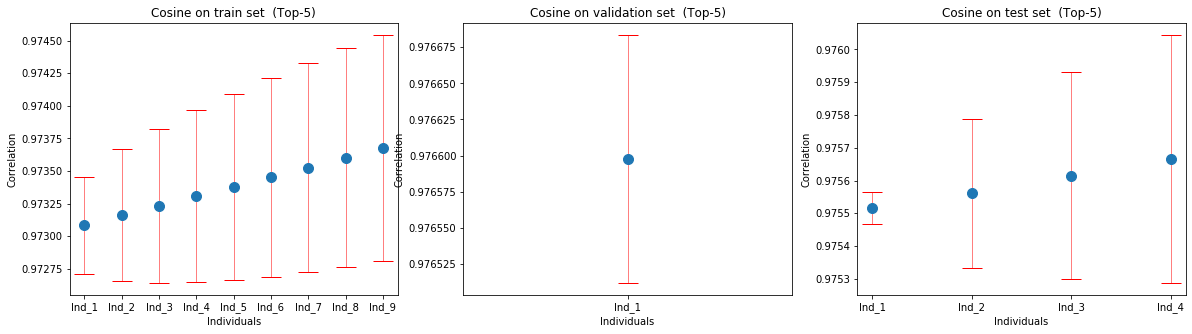

train set mean:  -0.9999794691801072
train set std:  1.1284471001450106e-05
validation set mean:  -0.9999477192759514
validation set std:  8.331491614571347e-06
test set mean:  -0.9999356788396835
test set std:  1.826827357049064e-05


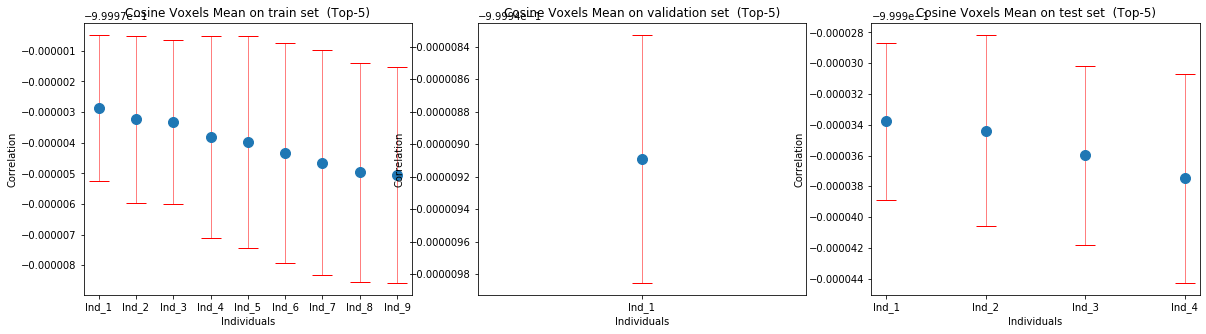

train set mean:  2761.6338826497395
train set std:  30.746588645155054
validation set mean:  3131.445551554362
validation set std:  1.9169887093075588
test set mean:  3128.40123046875
test set std:  7.171997890734322


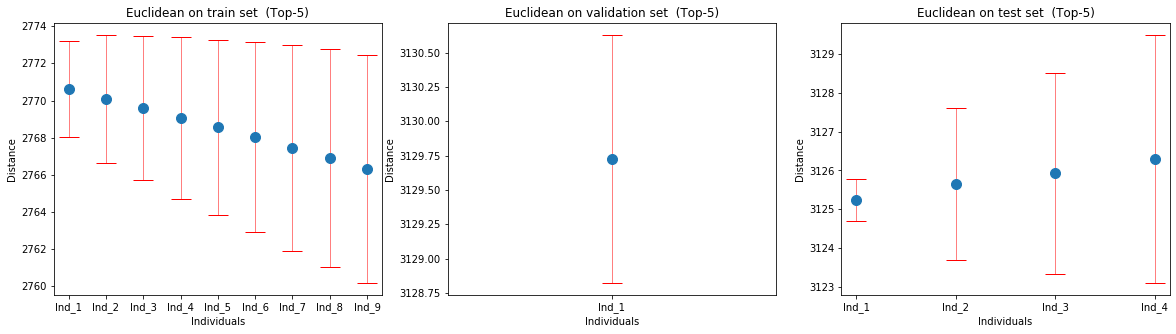

train set mean:  10333.0875
train set std:  115.04318818478986
validation set mean:  11716.79600016276
validation set std:  7.172372852627546
test set mean:  11705.40501953125
test set std:  26.834921071309804


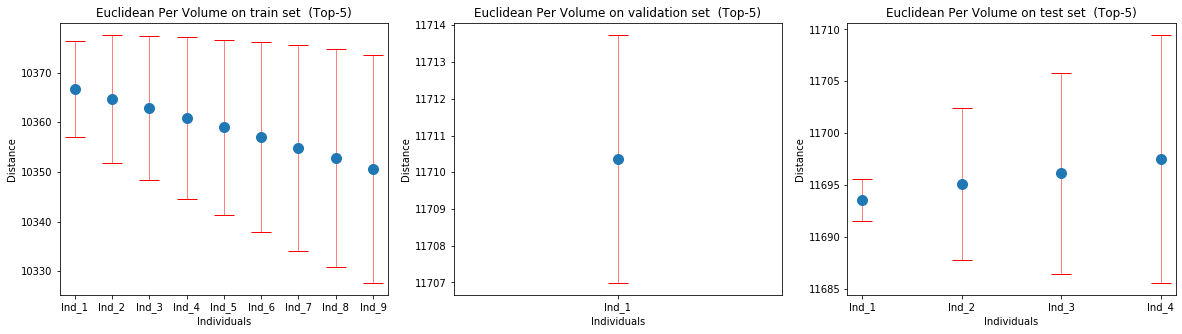

In [13]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name, n_partitions=n_partitions)